In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
from scipy.optimize import fsolve

In [2]:
#this is the advect upwind method
def advect_upwind(a,CFL,T,x=[],u0=[]):
    """solution of the 1D advection equation u_t+au_x=0.
    a>0 is assumed to be a positive constant
    CFL is the desired CFL number
    T is the final time that the simulation will be run
    x is the pre-selected spatial variable, and should be -
    uniformly distributed
    u0 is the initial condition, and must be the same size as x
    Returns an array u which is the solution at all time steps -
    up to T
    as dictated by the time-step chosen through the specified -
    CFL number."""
    N = len(x)
    L = x[-1]
    deltaX = 2*L/(N-1)
    deltaT=CFL*deltaX/np.abs(a)
    u = []
    u.append(u0)
    v = u0.copy() #a dummy variable for the update process
    for nn in range(1,int(T/deltaT)):
        for jj in range(1,N):
            v[jj] = u[nn-1][jj] - CFL*(u[nn-1][jj] - u[nn-1][jj-1])
        #Now we handle the periodic BCs
        v[0] = u[nn-1][0] - CFL*(u[nn-1][0] - u[nn-1][-1])
        u.append(v.copy())
    return x, np.array(u)

# Exercise 8.23 Part(i)
Making the lax_wendroff method work for the advection equation

In [3]:
#this is the lax_wendroff method
def lax_wendroff(a,CFL,T,x=[],u0=[]):
    """solution of the 1D advection equation u_t+au_x=0.
    a>0 is assumed to be a positive constant
    CFL is the desired CFL number
    T is the final time that the simulation will be run
    x is the pre-selected spatial variable, and should be -
    uniformly distributed
    u0 is the initial condition, and must be the same size as x
    Returns an array u which is the solution at all time steps -
    up to T
    as dictated by the time-step chosen through the specified -
    CFL number."""
    N = len(x)
    L = x[-1]
    deltaX = 2*L/(N-1)
    deltaT=CFL*deltaX/a
    u = []
    u.append(u0)
    v = u0.copy() #a dummy variable for the update process
    for nn in range(1,int(T/deltaT)):
        for jj in range(1,N-1):
            v[jj] = u[nn-1][jj] - CFL/2*(u[nn-1][jj+1] - u[nn-1][jj-1])
            v[jj] += CFL**2/2*(u[nn-1][jj+1] - 2*u[nn-1][jj] + u[nn-1][jj-1])
        #Now we handle the periodic BCs
        v[0] = u[nn-1][0]-CFL/2*(u[nn-1][1] - u[nn-1][-1])
        v[0] += CFL**2/2 *(u[nn-1][1] - 2*u[nn-1][0] + u[nn-1][-1])
        v[-1] = u[nn-1][-1] - CFL/2 * (u[nn-1][0] - u[nn-1][-2])
        v[-1] += CFL**2/2 *(u[nn-1][0] - 2*u[nn-1][-1] + u[nn-1][-2])
        u.append(v.copy())
    return x, np.array(u)
  

In [4]:
#this gives me the values i need
def prob8_23_vals():
    a = 1
    domain = [-np.pi, np.pi]
    x = np.linspace(domain[0], domain[-1], 500)
    u0 = np.sin(x)
    T = 10
    CFL = 1/2.
    #call the advection function
    x_upwind, u_upwind = advect_upwind(a, CFL, T, x, u0)
    #call the lax_wendroff method 
    x_lax, u_lax = lax_wendroff(a, CFL, T, x, u0)

    return x_upwind, u_upwind, x_lax, u_lax, x

In [5]:
x_upwind, u_upwind, x_lax, u_lax, x = prob8_23_vals()

# 8.23 Part (ii) 
Animation for upwind scheme

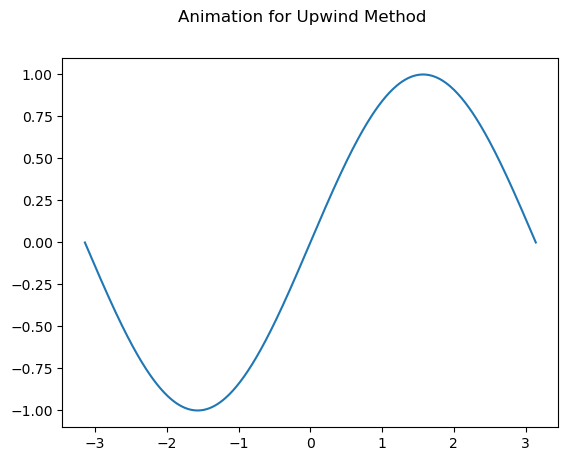

In [6]:
#set up first animation
plt.ioff()
fig = plt.figure()
fig.set_dpi(100)
ax = fig.add_subplot(111)
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-1, 1)
plt.suptitle(r'Animation for Upwind Method')
#update function for animation
def update(i):
    ax.clear()
    ax.plot(x_upwind, u_upwind[i])
    return ax
#create animation 
ani = animation.FuncAnimation(fig, update, frames = u_upwind.shape[0], interval=5)
HTML(ani.to_html5_video())

# 8.23 Part (iii)
Create animation for Lax-Wendroff method

In [7]:
plt.ioff()
fig1 = plt.figure()
fig1.set_dpi(100)
#Create the linspaces
ax1 = fig1.add_subplot(111)
ax1.set_xlim(-np.pi, np.pi)
ax1.set_ylim(-1,1)
plt.suptitle(r'Animation for Lax-Wendroff Method')
#new update function
def update_lax(i):
    ax1.clear()
    ax1.plot(x_lax, u_lax[i])
    return ax1
ani1 = animation.FuncAnimation(fig1, update_lax, frames = u_lax.shape[0], interval=25)
HTML(ani1.to_html5_video())

Notice that the animation for the Lax-Wendroff method is "more wavy".
For both methods there is some precession, meaning the $u$ value output is bounded between $[-1, 1]$ but as space goes on the bound gets smaller as the solution preceeds inward. This happens for both methods and is probably the manifestation of numerical error but it happens a lot less for the Lax-Wendroff method since it is a second order method as opposed to the upwind's first order method. 
 is most likely due to numerical error but it happens  

# Exercise 8.24 Part (i)
Creating the downwind algorithm for $a < 0$

In [8]:
def advect_upwind_gen_a(a,CFL,T,x=[],u0=[]):
    """solution of the 1D advection equation u_t+au_x=0.
    a is assumed now to be a nonzero constant
    CFL is the desired CFL number
    T is the final time that the simulation will be run
    x is the pre-selected spatial variable, and should be -
    uniformly distributed
    u0 is the initial condition, and must be the same size as x
    Returns an array u which is the solution at all time steps -
    up to T
    as dictated by the time-step chosen through the specified -
    CFL number."""
    N = len(x)
    L = x[-1]
    deltaX = 2*L/(N-1)
    deltaT=CFL*deltaX/np.abs(a)
    u = []
    u.append(u0)
    v = u0.copy() #a dummy variable for the update process
    for nn in range(1,int(T/deltaT)):
        #adjust our ranging from 0 to N-1
        for jj in range(0, N):
            #use 8.13 in the book
            if a < 0:
                #here is where we set the boundary condition
                if jj == N-1:
                    v[-1] = u[nn-1][-1] - CFL*(u[nn-1][0] - u[nn-1][-1])
                #here is where we use equation 8.13
                else:
                    v[jj] = u[nn-1][jj] - CFL*(u[nn-1][jj+1] - u[nn-1][jj])

            #otherwise use the same formula as before
            else:
              #skip over the 0th entry (we set this at the end) 
              if jj == 0:
                continue
              #update and set our BC
              elif jj == N-1:
                  #update on last element
                  v[jj] = u[nn-1][jj] - CFL*(u[nn-1][jj] - u[nn-1][jj-1])
                  #now set the BC
                  v[0] = u[nn-1][0] - CFL*(u[nn-1][0] - u[nn-1][-1])
              #otherwise just a normal loop
              else:
                  v[jj] = u[nn-1][jj] - CFL*(u[nn-1][jj] - u[nn-1][jj-1])

        #append our update
        u.append(v.copy())
    return x, np.array(u)

In [9]:
#gives me the values I want
def prob8_24_vals():
    a1 = 1
    a2 = -1
    domain = [-np.pi, np.pi]
    x = np.linspace(domain[0], domain[-1], 100)
    u0 = np.sin(x)
    T = 5
    CFL = 1/2.

    x_upwind, u_upwind = advect_upwind_gen_a(a1, CFL, T, x, u0)
    x_downwind, u_downwind = advect_upwind_gen_a(a2, CFL, T, x, u0)

    return x_upwind, u_upwind, x_downwind, u_downwind

x_upwind, u_upwind, x_downwind, u_downwind = prob8_24_vals()

# Exericse 8.24 Part (ii) 
Creating our comparative animations

In [10]:
#set up first animation
plt.ioff()
fig = plt.figure()
fig.set_dpi(100)
ax = fig.add_subplot(111)
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-1, 1)
plt.suptitle(r'Animation for $a> 0$.')
#update function for animation
def update(i):
    ax.clear()
    ax.plot(x_upwind, u_upwind[i])
    return ax
        
#create animation 
ani = animation.FuncAnimation(fig, update, frames = u_upwind.shape[0], interval=25)
HTML(ani.to_html5_video())

In [11]:
#set up first animation
plt.ioff()
fig = plt.figure()
fig.set_dpi(100)
ax = fig.add_subplot(111)
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-1, 1)
plt.suptitle(r'Animation for $a < 0$.')
#update function for animation
def update(i):
    ax.clear()
    ax.set_yticks([])
    ax.plot(x_downwind, u_downwind[i])
    return ax
#create animation 
ani = animation.FuncAnimation(fig, update, frames = u_upwind.shape[0], interval=25)
HTML(ani.to_html5_video())

For $a > 0$ the solution is as it was before (with some precession) but notice that in the animation for $a< 0$ the function first looks like the sine wave we had before but then goes into some weird oscillations. This is most likely a numerical stability error because the mess that follows is still oscillating like a sign wave but with most-likely overflow errors causing the wild behavior we see here.

# Exericse 8.25 Parti (i) 
Here we define our new algorithm for the $a(x)$ where we have to switch between the methods depending on if $a(x_i) > 0$ or $a(x_i) < 0$.
The first thing to consider is how do we pick or CFL number, the $\Delta x$ will remain the same as that depends on our spatial discretization. 
Before we used our $CFL = \frac{a\Delta t}{\Delta x}$ number to define our $\Delta t$ but how do we do this now that $a$ is no longer constant when we want $CFL < 1$? We do this by selecting the smallest value for $\Delta t$ that we can. E.g. $\Delta t =  CFL_0 \Delta x /\max{(|a(x_i)|)}$ over the discretized spatial coordinates where $CFL_0$ is the $CFL$ condition passed into the function. Now, we calculate a new $CFL$ value for each step. i.e. $CFL_i = \frac{a(x_i)\Delta t}{\Delta x}$ but now $\Delta t$ is chosen so that the $CFL_i \leq CFL_0$.

In [12]:
def advect_upwind_gen(a,CFL,T,x=[],u0=[]):
    """solution of the 1D advection equation u_t+au_x=0.
    a is a callable function. 
    CFL is the desired CFL number
    T is the final time that the simulation will be run
    x is the pre-selected spatial variable, and should be -
    uniformly distributed
    u0 is the initial condition, and must be the same size as x
    Returns an array u which is the solution at all time steps -
    up to T
    as dictated by the time-step chosen through the specified -
    CFL number."""
    N = len(x)
    L = x[-1]
    deltaX = 2*L/(N-1)
    #get delta T term where we use the max of $a$ over the discretized
    #spatial values
    deltaT=CFL*deltaX/np.max(np.abs(a(x)))
    u = []
    u.append(u0)
    v = u0.copy() #a dummy variable for the update process
    for nn in range(1,int(T/deltaT)):
        #adjust our ranging from 0 to N-1
        for jj in range(0, N):
            #if the current a value is less than zero
            #use 8.13 in the book
            if a(x[jj]) < 0:
                #here is where we set the boundary condition
                if jj == N-1:
                    v[-1] = u[nn-1][-1] - a(x[-1])*deltaT/(deltaX)*(u[nn-1][0] - u[nn-1][-1])
                #here is where we use equation 8.13
                else:
                    v[jj] = u[nn-1][jj] - a(x[jj])*deltaT/(deltaX)*(u[nn-1][jj+1] - u[nn-1][jj])

            #if the current a value is greater than zero
            #otherwise use the same formula as before
            elif a(x[jj]) > 0:
              #skip over the 0th entry (we set this at the end) 
              if jj == 0:
                continue
              #update and set our BC
              elif jj == N-1:
                  #update on last element
                  v[jj] = u[nn-1][jj] - a(x[jj])*deltaT/(deltaX)*(u[nn-1][jj] - u[nn-1][jj-1])
                  #now set the BC
                  v[0] = u[nn-1][0] - a(x[0])*deltaT/(deltaX)*(u[nn-1][0] - u[nn-1][-1])
              #otherwise just a normal loop
              else:
                  v[jj] = u[nn-1][jj] - a(x[jj])*deltaT/deltaX*(u[nn-1][jj] - u[nn-1][jj-1])

        #append our update
        u.append(v.copy())
    return x, np.array(u)

In [13]:
def prob8_25_vals():
    a = lambda x: 2 + np.cos(x)
    domain = [-np.pi, np.pi]
    x = np.linspace(domain[0], domain[-1], 100)
    u0 = np.sin(x)
    T = 5
    CFL = 1/2.
    x_vals, u_vals = advect_upwind_gen(a, CFL, T, x, u0)

    return x_vals, u_vals

x_vals, u_vals = prob8_25_vals()

# Exericse 8.25 Part (ii)
Here we make the animation for the problem

In [14]:
#set up first animation
plt.ioff()
fig = plt.figure()
fig.set_dpi(100)
ax = fig.add_subplot(111)
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-1, 1)
plt.suptitle(r'Animation for $a(x) = 2 + \cos(x)$.')
#update function for animation
def update(i):
    ax.clear()
    ax.set_yticks([])
    ax.plot(x_vals, u_vals[i])
    return ax
#create animation 
ani = animation.FuncAnimation(fig, update, frames = u_vals.shape[0], interval=25)
HTML(ani.to_html5_video())